In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Image 2 under Harris corner detector')

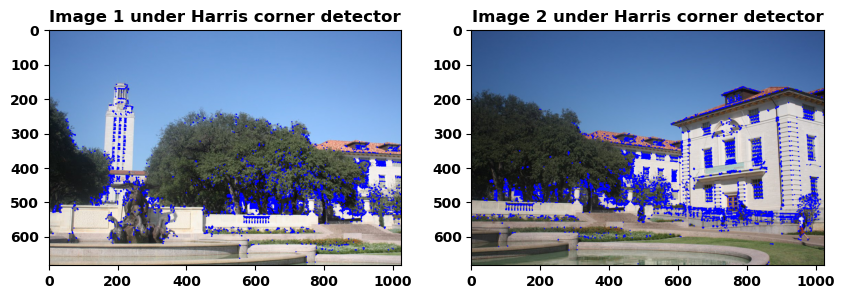

In [2]:
#This will run as a standalone. Only for the first part of report.
#Feature detection using Harris corner detection
image1_color = cv2.imread('./image pairs/image pairs_03_01.jpg', 1)
image2_color = cv2.imread('./image pairs/image pairs_03_02.jpg', 1)

image1_color = cv2.cvtColor(image1_color, cv2.COLOR_BGR2RGB)
image2_color = cv2.cvtColor(image2_color, cv2.COLOR_BGR2RGB)

# Convert to grayscale
image1_gray = np.float32(cv2.cvtColor(image1_color, cv2.COLOR_BGR2GRAY))        #Grayscale images
image2_gray = np.float32(cv2.cvtColor(image2_color, cv2.COLOR_BGR2GRAY))

# Apply Harris Corner Detection
dst1 = cv2.cornerHarris(image1_gray, 2, 3, 0.04)
dst2 = cv2.cornerHarris(image2_gray, 2, 3, 0.04)

# Dilate to mark the corners
dst1 = cv2.dilate(dst1, None)
dst2 = cv2.dilate(dst2, None)

# Threshold for an optimal value, it may vary depending on the image
image1_color[dst1 > 0.01 * dst1.max()] = [0, 0, 255]
image2_color[dst2 > 0.01 * dst2.max()] = [0, 0, 255]

plt.figure(figsize = (10,20))

plt.subplot(1,2,1)
plt.imshow(image1_color, cmap = 'gray')
plt.title('Image 1 under Harris corner detector')

plt.subplot(1,2,2)
plt.imshow(image2_color, cmap = 'gray')
plt.title('Image 2 under Harris corner detector')


## From here on, it is using SIFT and stitching

In [3]:
image1_color = cv2.imread('./image pairs/image pairs_03_01.jpg', 1)
image2_color = cv2.imread('./image pairs/image pairs_03_02.jpg', 1)

# image1_gray = cv2.cvtColor(image1_color, cv2.COLOR_BGR2GRAY)
# image2_gray = cv2.cvtColor(image2_color, cv2.COLOR_BGR2GRAY)
image1_gray = cv2.cvtColor(image1_color, cv2.COLOR_BGR2RGB)     #For matplotlib, RGB images
image2_gray = cv2.cvtColor(image2_color, cv2.COLOR_BGR2RGB)     #Images are not actually grayscale

In [4]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray, None)
kp2, des2 = sift.detectAndCompute(image2_gray, None)

Text(0.5, 1.0, 'output2')

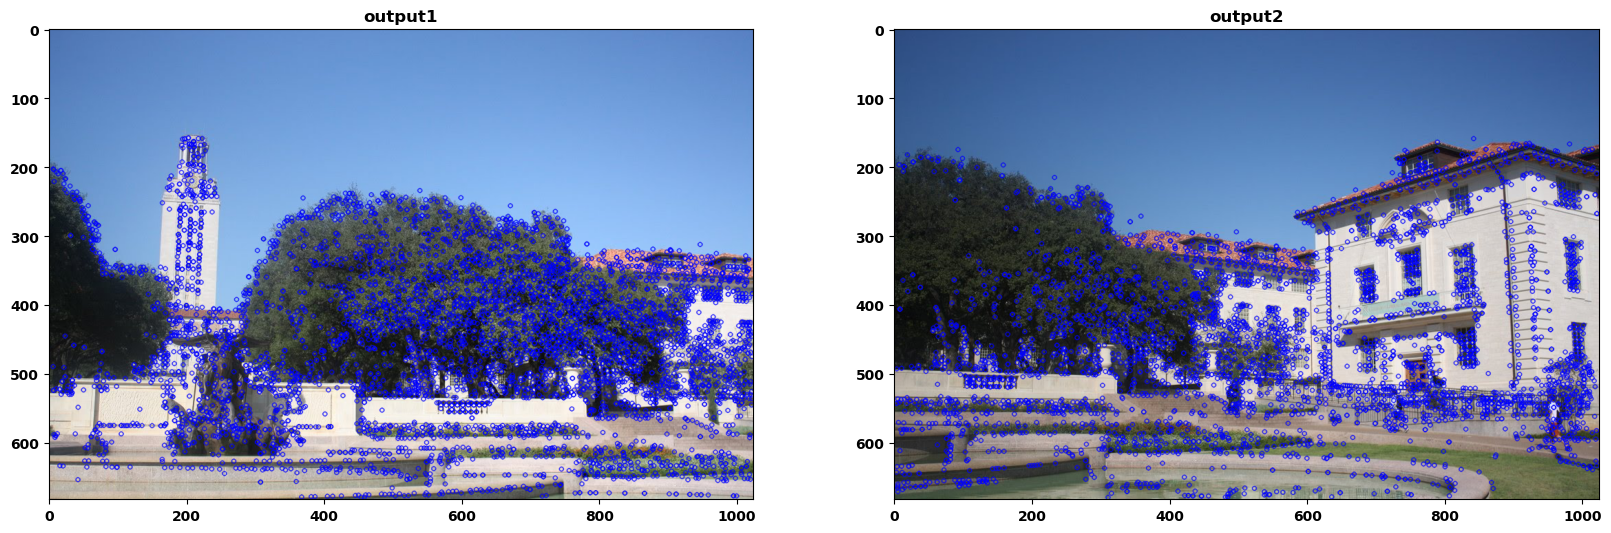

In [5]:
output1 = cv2.drawKeypoints(image1_gray, kp1, 0, color=(0, 0, 255))
output2 = cv2.drawKeypoints(image2_gray, kp2, 0, color=(0, 0, 255))

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(output1)
plt.title('output1')

plt.subplot(1,2,2)
plt.imshow(output2)
plt.title('output2')

In [6]:
#Normalize descriptors before comparing descriptors
mean1 = np.mean(des1, axis=0)
mean2 = np.mean(des2, axis=0)

std1 = np.std(des1, axis=0)
std2 = np.std(des2, axis=0)

des1 = (des1-mean1)/std1
des2 = (des2-mean2)/std2

In [7]:
#Compare descriptors
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)       #NORM_L2 is Euclidean distance



# Compare the vectors in des1 and des2
matches = bf.knnMatch(des1, des2, k = 2)    #Output the best two matches from des2, for des1.

good_matches = []
r = 0.3     #SSD ratio for the top 2 matches
for k in range(len(matches)-1):
    if matches[k][0].distance < r * matches[k][1].distance:
        ratio = matches[k][0].distance/matches[k][1].distance
        good_matches.append(matches[k][0])

print(len(good_matches))        #At least 4 pairs of good matches for the homography.


# Extract location of good matches
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

drawpoints1 = [None]*len(matches)
drawpoints2 = [None]*len(matches)


for i, match in enumerate(good_matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
    
    
    drawpoints1[i] = kp1[match.queryIdx]
    drawpoints2[i] = kp2[match.trainIdx]

print(points1.shape)

83
(83, 2)


Text(0.5, 1.0, 'matching')

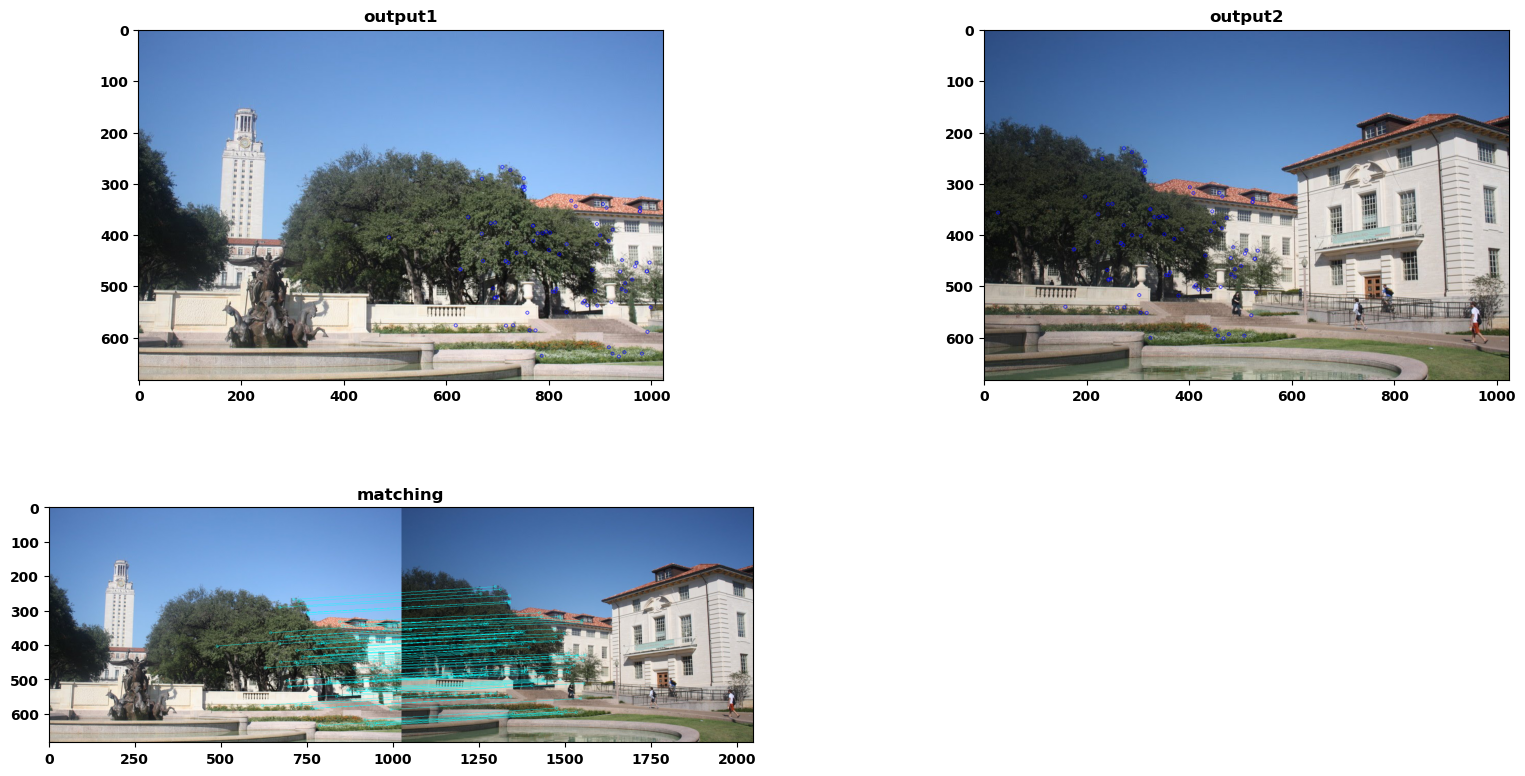

In [8]:
#Show the keypoints used
def draw_matches(image1, points1, image2, points2): 
    h1, w1= image1.shape[:2]
    h2, w2 = image2.shape[:2]

    # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([h1, h2]), w1+w2, 3), dtype='uint8')
    output_img[:h1, :w1, :] = image1[:,:,:]
    output_img[:h2, w1:w1+w2, :] = image2[:,:,:]
    
    for (x1,y1), (x2,y2) in zip(points1, points2):
        cv2.circle(output_img, (int(x1), int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+w1,int(y2)), 4, (0, 255, 255), 1)
        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+w1,int(y2)), (0, 255, 255), 1)

    return(output_img)
    
    

output1 = cv2.drawKeypoints(image1_gray, drawpoints1, 0, color=(0, 0, 255))
output2 = cv2.drawKeypoints(image2_gray, drawpoints2, 0, color=(0, 0, 255))
output3 = draw_matches(image1_gray, points1, image2_gray, points2)

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.imshow(output1, cmap ='gray')
plt.title('output1')

plt.subplot(2,2,2)
plt.imshow(output2)
plt.title('output2')

plt.subplot(2,2,3)
plt.imshow(output3)
plt.title('matching')

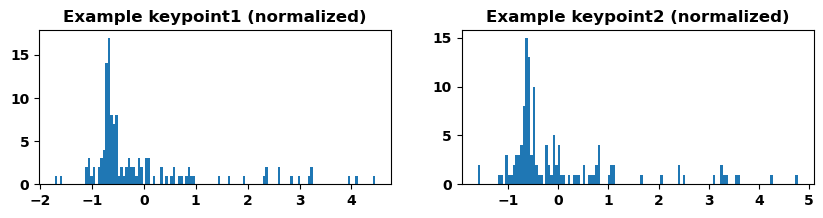

In [9]:
#Visualize the key points

des1_match = np.zeros((len(good_matches), 128), dtype=np.float32)
des2_match = np.zeros((len(good_matches), 128), dtype=np.float32)

for i, match in enumerate(good_matches):
    des1_match[i,:] = des1[match.queryIdx]
    des2_match[i,:] = des2[match.trainIdx]
    
plt.figure(figsize = (10,2))
plt.subplot(1,2,1)
vect11_hist = plt.hist(des1_match[1,:], 128)
plt.title('Example keypoint1 (normalized)')

plt.subplot(1,2,2)
vect12_hist = plt.hist(des2_match[1,:], 128)
plt.title('Example keypoint2 (normalized)')
plt.show()


'\nplt.subplot(2,2,3)\nplt.imshow(image2_gray)\nplt.title("Original image 2")\n'

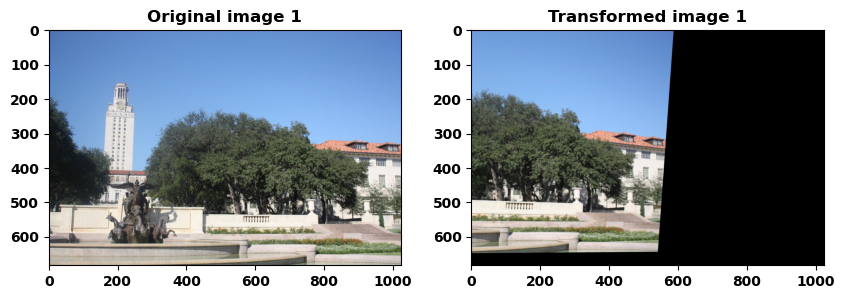

In [15]:
#Find homography matrix and perspective matrix. Apply to images and stitch.
H, mask = cv2.findHomography(np.int32(points1), np.int32(points2), method=cv2.RANSAC, ransacReprojThreshold=3.0)        #Get homography matrix from noisy data using RANSAC

#Depiction of the transformed image
transformed_image1 = cv2.warpPerspective(image1_gray, H, (image2_gray.shape[1], image2_gray.shape[0]))



plt.figure(figsize=(10,20))

plt.subplot(2,2,1)
plt.imshow(image1_gray)
plt.title("Original image 1")

plt.subplot(2,2,2)
plt.imshow(transformed_image1)
plt.title("Transformed image 1")

'''
plt.subplot(2,2,3)
plt.imshow(image2_gray)
plt.title("Original image 2")
'''

In [16]:
#Stitching: Find the translation matrix to include entirety of image 1 and 2 as output.

h1, w1 = image1_gray.shape[:2]  #For RGB images
h2, w2 = image2_gray.shape[:2]

corners1 = np.float32(np.reshape([[0,0], [w1, 0], [w1, h1], [0, h1]], (-1, 1, 2)))
corners2 = np.float32(np.reshape([[0,0], [w2, 0], [w2, h2], [0, h2]], (-1, 1, 2)))
corners1 = cv2.perspectiveTransform(corners1, m=H)      #Projected corners of picture 1.


corners = np.concatenate((corners1, corners2), axis = 0)

x_min, y_min = np.int32(np.min(corners, axis = 0)-0.5)[0] #find the output width and height of the new image, bounded by min or corners1 and corners2.
x_max, y_max = np.int32(np.max(corners, axis = 0)+0.5)[0] #the plus/minus 0.5 ensures the rounding up and rounding down of the values


T = cv2.getPerspectiveTransform(corners1, corners1 + np.float32([np.abs(x_min), np.abs(y_min)]))    #Homography matrix to determine how image is being translated (data known to be non-noisy)


output = cv2.warpPerspective(image1_gray, np.matmul(T,H), dsize=(np.abs(x_max)+np.abs(x_min), np.abs(y_max)+np.abs(y_min)))    #disze = image output size. Apply H then T (transform then transalte)
output[np.abs(y_min): h2 + np.abs(y_min), np.abs(x_min): w2 + np.abs(x_min)] = image2_gray      #this is the RHS of the image.


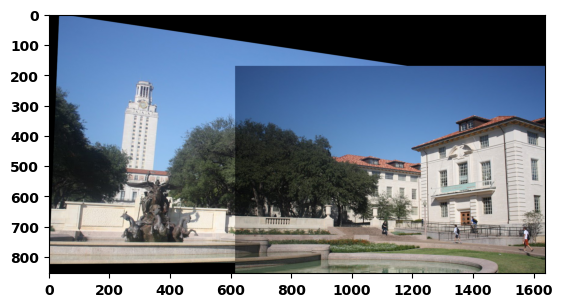

In [17]:
plt.imshow(output)

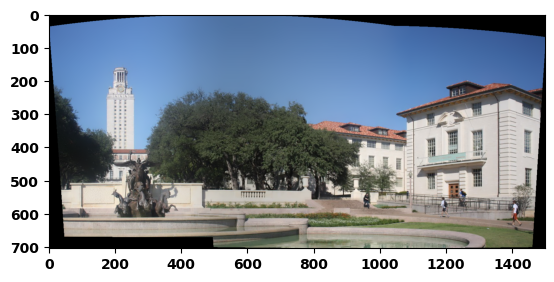

In [13]:
#stitching library from opencv (with multiband blending and gain compensation)
import cv2

# Create a Stitcher object
stitcher = cv2.Stitcher_create()

# Load the images you want to stitch together
image1 = cv2.imread("./image pairs/image pairs_03_01.jpg")
image2 = cv2.imread("./image pairs/image pairs_03_02.jpg")


image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
# Use the stitch() method to stitch the images together
result = stitcher.stitch((image1, image2))

# The result is a tuple where the first element is a status code and the second element is the stitched image
if result[0] == cv2.Stitcher_OK:
    # Save the stitched image
    #cv2.imwrite("well_stitched_image.jpg", result[1])
    result_RGB= cv2.cvtColor(result[1], cv2.COLOR_BGR2RGB)
    plt.imshow(result_RGB)
else:
    print("Error during stitching, error code =", result[0])
    

